## <center> LGBM model. Tuning and creating submission

### Load train/test files from feature_eng notebooks.

In [36]:
%store -r X_train
%store -r X_test

%store -r y_train
%store -r y_test

%store -r X_train_sub
%store -r X_test_sub
%store -r y_train_sub
%store -r y_test_sub

### Import libraries

In [ ]:
send_submission = False

In [ ]:
_da

In [1]:
# SKLEARN
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score,

# LightGBM
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

/Users/maksymsuprunenko/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py:604: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



## LightGBM feature tuning

RandomizedSearch was used for parameter tuning LightGBM model. RandomizedSearch used time series split which compraise of 5 folds.

In [52]:
cat_feats = ['shop_id', 'key', 'item_category_id', 'item_id',  'city',
             'item_category_names_category_1_enc', 'item_category_names_category_2_enc']


In [ ]:
def get_lgbm(params = {}):
    return LGBMRegressor(
           boosting_type= 'gbdt',
           objective = 'rmse',
           metric = "rmse",
           random_state= 1,
           silent = True,
           **params)

def create_submission(model, submission_name, send_submission=False, message="LGBM"):
    result = model.predict(X_test_sub)
    submission = pd.DataFrame({
        "ID": np.arange(result.shape[0]), 
        "item_cnt_month": result
    })
    submission.to_csv(submission_name, index=False)
   
    if send_submission:
        !kaggle competitions submit -c competitive-data-science-predict-future-sales -f {submission_name} -m {message}

In [3]:
%%notify -m "Grid search LGBM was ended"

gridParams = {
    'learning_rate': np.linspace(0.01, 2, 10),
    'max_depth': np.arange(0, 14),
    'n_estimators': np.arange(100, 1000, 100),
    'num_leaves': np.arange(8, 65, 8),
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : np.arange(0.5, 1.1, 0.1),
    'reg_alpha' : np.arange(0, 100),
    'reg_lambda' : np.arange(0, 100)
}

lgbm = get_lgbm()

# Create the grid
grid = RandomizedSearchCV(lgbm, gridParams, verbose=0, cv=TimeSeriesSplit(n_splits=5))
grid.fit(X_train, y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
#    evals_result=evals_result,
    verbose=10, 
    early_stopping_rounds=20,
    categorical_feature = cat_feats)


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 1.05679	valid_1's rmse: 1.02615
[20]	valid_0's rmse: 1.07602	valid_1's rmse: 1.04882
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.954846	valid_1's rmse: 0.93576
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.956666	valid_1's rmse: 1.01296
[20]	valid_0's rmse: 0.958657	valid_1's rmse: 1.02448
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.930743	valid_1's rmse: 0.894831
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.895367	valid_1's rmse: 1.04999
[20]	valid_0's rmse: 0.895504	valid_1's rmse: 1.05982
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.89626	valid_1's rmse: 0.875266
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.836915	valid_1's rmse: 0.953665
[20]	valid_0's rmse: 0.823135	valid_1's rmse: 0.947601
Early stopping, best iteration is:
[2]	valid_0's rmse: 

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.911367	valid_1's rmse: 1.09477
[20]	valid_0's rmse: 0.914545	valid_1's rmse: 1.09976
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.871903	valid_1's rmse: 0.93382
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.852285	valid_1's rmse: 1.05097
[20]	valid_0's rmse: 0.844788	valid_1's rmse: 1.0538
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.894753	valid_1's rmse: 1.01599
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.790183	valid_1's rmse: 0.988931
[20]	valid_0's rmse: 0.775323	valid_1's rmse: 1.00288
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.835146	valid_1's rmse: 0.87805
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.752038	valid_1's rmse: 1.05377
[20]	valid_0's rmse: 0.728949	valid_1's rmse: 1.05493
Early stopping, best iteration is:
[1]	valid_0's rmse: 0

<IPython.core.display.Javascript object>

In [ ]:
print("Score", grid.best_score_)
print('Fitting with params: ')
print(grid.best_params_)

In [ ]:
rmse =  np.sqrt(mean_squared_error(y_test, grid.best_estimator.predict(X_test))) 
print(f"RMSE {rmse}")

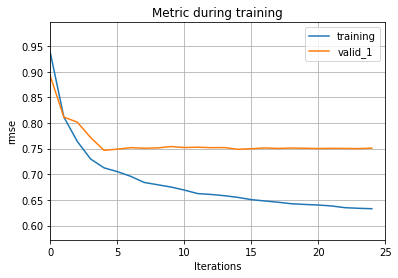

In [62]:
ax = lgb.plot_metric(grid.best_estimator_)
plt.show()

Tuned parameters from RandomizedSearch.

In [53]:
params = {'subsample': 0.89,
 'reg_lambda': 11,
 'reg_alpha': 32,
 'num_leaves': 40,
 'n_estimators': 400,
 'max_depth': 7,
 'learning_rate': 0.45222222222222225,
 'colsample_bytree': 0.66}

In [54]:
%%notify -m "LGBMRegressor submission have been fit"

lgbm = get_lgbm(params)
lgbm.fit(X_train_sub, y_train_sub, 
    eval_metric="rmse", 
    eval_set=[(X_train_sub, y_train_sub)], 
    verbose=0, 
    early_stopping_rounds=20,
    categorical_feature = cat_feats)    

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 0.68996
[20]	valid_0's rmse: 0.656443
[30]	valid_0's rmse: 0.645768
[40]	valid_0's rmse: 0.633986
[50]	valid_0's rmse: 0.626282
[60]	valid_0's rmse: 0.61744
[70]	valid_0's rmse: 0.609957
[80]	valid_0's rmse: 0.605575
[90]	valid_0's rmse: 0.601665
[100]	valid_0's rmse: 0.59803
[110]	valid_0's rmse: 0.593276
[120]	valid_0's rmse: 0.592163
[130]	valid_0's rmse: 0.589296
[140]	valid_0's rmse: 0.588748
[150]	valid_0's rmse: 0.58611
[160]	valid_0's rmse: 0.583693
[170]	valid_0's rmse: 0.581844
[180]	valid_0's rmse: 0.580142
[190]	valid_0's rmse: 0.578456
[200]	valid_0's rmse: 0.574926
[210]	valid_0's rmse: 0.573178
[220]	valid_0's rmse: 0.570977
[230]	valid_0's rmse: 0.569454
[240]	valid_0's rmse: 0.567861
[250]	valid_0's rmse: 0.56677
[260]	valid_0's rmse: 0.564603
[270]	valid_0's rmse: 0.561923
[280]	valid_0's rmse: 0.560562
[290]	valid_0's rmse: 0.558575
[300]	valid_0's rmse: 0.557084
[310]	valid_0's rmse: 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
              importance_type='split', learning_rate=0.45222222222222225,
              max_depth=7, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
              n_jobs=-1, num_leaves=40, objective='rmse', random_state=1,
              reg_alpha=32, reg_lambda=11, silent=True, subsample=0.89,
              subsample_for_bin=200000, subsample_freq=0)

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax = lgb.plot_importance(lgbm, max_num_features=20, ax=ax)
plt.show()

In [57]:
%%notify -m "Submission was created"
create_submission(lgbm, 'lgbm_submission_gs.csv', make_submission)

<IPython.core.display.Javascript object>

In [71]:
def lgbm_cross_validation(params):
    lgbm = LGBMRegressor(
       boosting_type= 'gbdt',
       objective = 'rmse',
       metric = "rmse",
       random_state= 1,
       silent = True)

    lgbm.fit(X_train, y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=0, 
        early_stopping_rounds=20,
        categorical_feature = cat_feats)
 
    pred = lgbm.predict(X_test)

    mse = np.sqrt(mean_squared_error((y_test), (pred)))

    return {'loss': mse, 'status': STATUS_OK, 'params': params }

def optimize_lgbm(max_evals=150):

    space = {
        'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    }
    
    trials = Trials()
    best = fmin(fn=lgbm_cross_validation,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                verbose= 1)

    # find the trial with lowest loss value. this is what we consider the best one
    idx = np.argmin(trials.losses())
    print(idx)

    print(trials.trials[idx])
    # these should be the training parameters to use to achieve the best score in best trial
    params = trials.trials[idx]["result"]["params"]

    print(params)
    return params

In [ ]:
%%notify -m "Hyperopt execution was finished"

hp_params = optimize_lgbm()
hp_params

 55%|█████▌    | 83/150 [3:24:38<1:44:44, 93.80s/it, best loss: 0.7353654013075203]  

In [ ]:
%%notify -m "Hyperopt tuned LGBMRegressor submission have been fit"

hp_lgbm = get_lgbm(hp_params)

hp_lgbm.fit(X_train_sub, y_train_sub, 
    eval_metric="rmse", 
    eval_set=[(X_train_sub, y_train_sub)], 
    verbose=0, 
    early_stopping_rounds=20,
    categorical_feature = cat_feats)    

In [ ]:
create_submission(hp_lgbm, 'lgbm_submission_hp.csv', send_submission)